In [17]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from annular.satellite_model import OptimizerBiddingStrategy

## Introduction

This notebook contains code for two things.
1. To run a single instance of a bidding strategy. This is instructive itself -- to see how they behave --, and useful for debugging and time profiling.
Currently, the notebook measures the execution time of a single call to `determine_bids` and `meet_demand`; for the latter, we use a random price.
2. Some code for investigating a discrepancy between market price and dispatched quantity

### Setup instructions:

This notebook depends on data generated by the scaling benchmarks.

1. Run the scaling benchmark for each spatial granularity you want to investigate
```bash
python run_benchmark.py --methods "market_auction" --spatial-granularities 2 --horizon-lengths 24 --output flavio_test
```
2. Set the constants below
 - `BENCHMARK_INPUT_PATH` points to the `input/` directory in your version of the scaling benchmark repository
 - `HORIZON_LENGTH` is the simulation horizon; it should be less than the `horizon-lengths` argument used to run the benchmark in step 1.
 - `GRANULARITIES` are all spatial granularities you want to explore.

Note that
- The higher the spatial granularity, the more agents there are.
- "spatial granularity" and "number of nodes" are used interchangeably in this notebook, following the code in the scaling benchmark.


In [18]:
BENCHMARK_INPUT_PATH = "/home/flavio/repositories/projects/DEMOSES/demoses-scaling-benchmarks/input/"
HORIZON_LENGTH = 4
GRANULARITIES = [1, 2]

In [ ]:
def load_experiment_inputs(n_nodes=1):
    """Load the data for the experiment.

    Args:
        n_nodes (int): number of nodes (which determine the spatial granularity,
        and thus the number of bidding agents).

    Returns:
        A dictionary with inputs for running timing experiments.

    This is a little cumbersome, and a better way to do it would be ot use
    the `initialize_strategy` function from annular. This would have to deal with
    the fact that paths in the config yamls are relative, and here we're accessing
    data in a different repository.
    """
    model_environment = f"pypsa-eur-DE-{n_nodes}-nodes"
    current_path = Path(BENCHMARK_INPUT_PATH, model_environment)
    prosumer_path = current_path / "prosumers"
    csv_files = {
        "electricity": "price_electricity.csv",
        "carrier_prices": "price_other_carriers.csv",
        "demands": "loads_generators_timeseries.csv",  # timeseries_data
    }
    demands = pd.read_csv(current_path / csv_files["demands"], index_col=0, parse_dates=True)
    carrier_prices = pd.read_csv(current_path / csv_files["carrier_prices"], index_col=0, parse_dates=True)
    forecast = pd.read_csv(current_path / "muscle3/forecast-prices.csv", index_col=0, parse_dates=True)
    prosumer_configs = [x.name for x in prosumer_path.iterdir()]

    inputs = {
        "n_nodes": n_nodes,
        "prosumer_configs": prosumer_configs,
        "prosumer_path": prosumer_path,
        "demands_df": demands,
        "forecast_df": forecast,
        "carrier_price_df": carrier_prices,
    }
    return inputs

In [ ]:
def time_satellite_bidding(input_data):
    """Time how long satellites take for creating bids.

    Calls `determine_bid` one time for each satellite in the prosumer configs.
    Measures running time, collects them in a dataframe.

    Args:
        input_data (dict): Data loaded with the `load_experiment_inputs` function.

    Returns:
        pd.DataFrame: Dataframe with time measurements per prosumer.

    Notes:
        This is not a performance benchmark, just a rough check of the variation
        in timing between different prosumers.
    """
    bid_times = {}
    meet_demand_times = {}
    for cfg in tqdm(input_data["prosumer_configs"]):
        strategy = OptimizerBiddingStrategy(
            demands=input_data["demands_df"],
            ceiling_price=500,  # see MUSCLE3 params in run_benchmark.py
            floor_price=0,
            electricity_price_forecast=input_data["forecast_df"],
            carrier_prices=input_data["carrier_price_df"],
            horizon_size=HORIZON_LENGTH,
            model_config_path=input_data["prosumer_path"] / cfg,
            storage_model="simple",
        )
        start = time.time()
        bid = strategy.determine_bids()
        end = time.time()
        bid_times[cfg] = end - start

        assert bid.index.get_level_values(0).nunique() == 1

        market_price = np.random.uniform(0, 500, 1)[0]
        allocation = bid.loc[bid["bid-price"] >= market_price]["quantity"].sum()

        start = time.time()
        strategy.meet_demand(market_price=[market_price], demand_met=[allocation])
        end = time.time()
        meet_demand_times[cfg] = end - start

    bid_time_df = pd.DataFrame(list(bid_times.items()), columns=["prosumer_config", "bid_time"])
    meet_demand_time_df = pd.DataFrame(list(meet_demand_times.items()), columns=["prosumer_config", "update_time"])
    timing_df = (
        bid_time_df.set_index(["prosumer_config"])
        .join(meet_demand_time_df.set_index(["prosumer_config"]))
        .reset_index()
    )
    timing_df["n_nodes"] = input_data["n_nodes"]
    return timing_df

In [21]:
experiment_data = []
for n_nodes in GRANULARITIES:
    print(f"Running with {n_nodes=}")
    input_data = load_experiment_inputs(n_nodes=n_nodes)
    timings = time_satellite_bidding(input_data)
    experiment_data.append(timings)

Running with n_nodes=1


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


Running with n_nodes=2


100%|███████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


In [22]:
experiment_df = pd.concat(experiment_data)
experiment_df["horizon_length"] = HORIZON_LENGTH
experiment_df["total_time"] = experiment_df["bid_time"] + experiment_df["update_time"]

In [23]:
experiment_df.head()

prosumer_config  bid_time  update_time  n_nodes  horizon_length  total_time
0       B002.yaml  0.113158     0.056277        1               4    0.169435
1       P002.yaml  0.834289     0.062268        1               4    0.896558
2       P003.yaml  1.252291     0.082560        1               4    1.334851
3       B004.yaml  0.121324     0.059263        1               4    0.180587
4       P001.yaml  3.053305     0.071052        1               4    3.124357

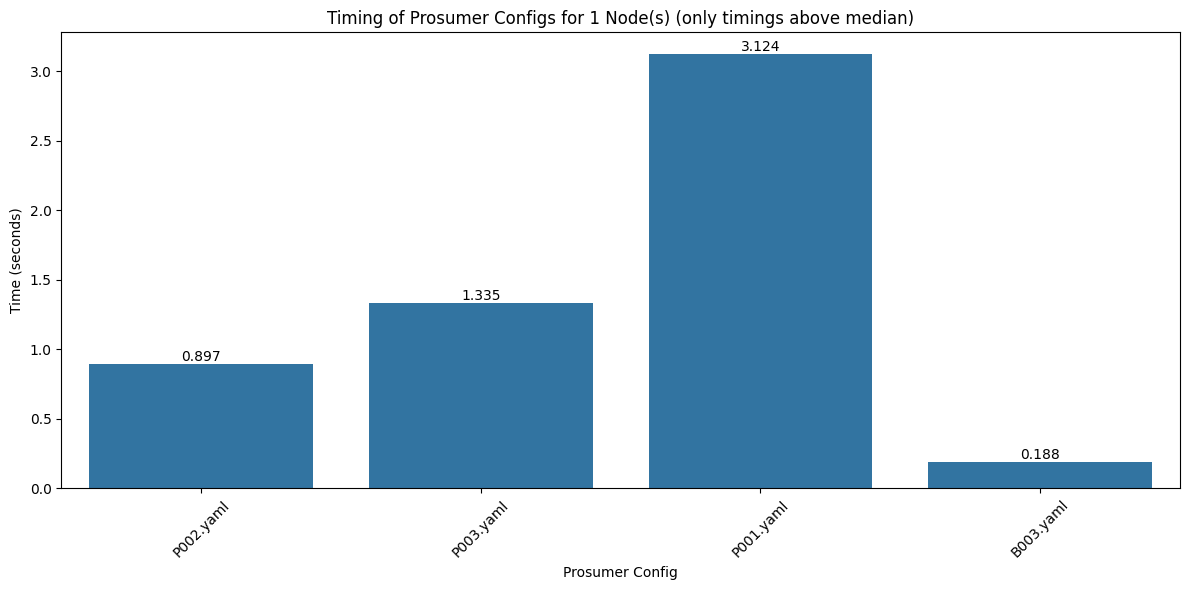

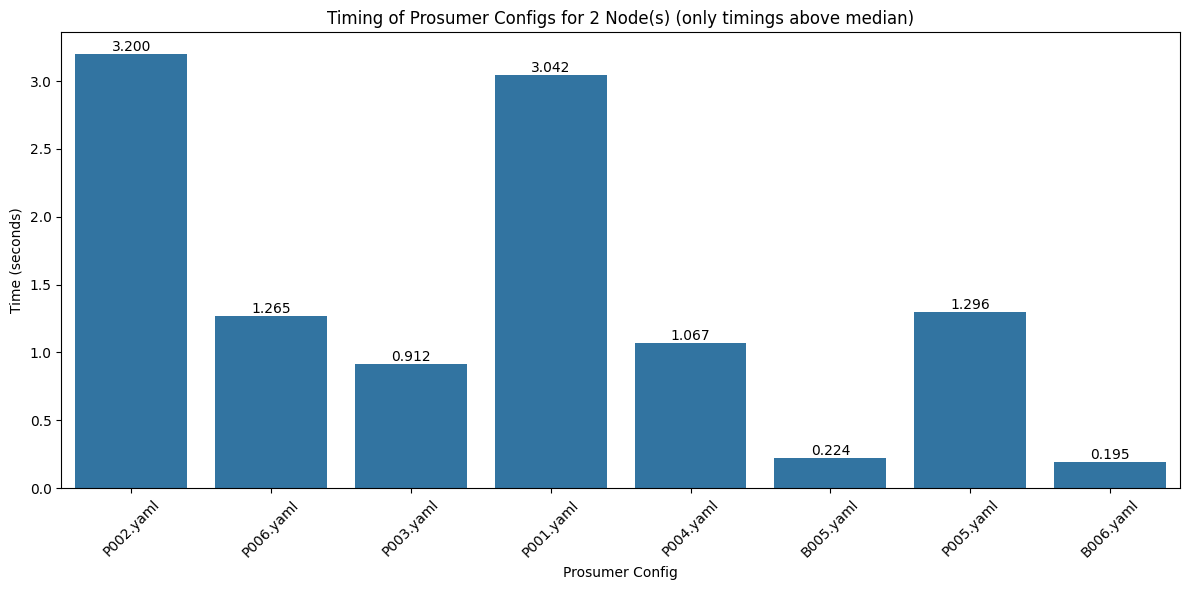

In [24]:
unique_nodes = experiment_df["n_nodes"].unique()

# Set up the plot style
time_variable = "total_time"

# Create a plot for each unique n_nodes value
for node in unique_nodes:
    # Filter data for current n_nodes
    node_data = experiment_df[experiment_df["n_nodes"] == node]
    median = np.median(node_data[time_variable])
    node_data = node_data.loc[node_data[time_variable] >= median]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Create bar plot
    sns.barplot(x="prosumer_config", y=time_variable, data=node_data)

    # Customize the plot
    plt.title(f"Timing of Prosumer Configs for {node} Node(s) (only timings above median)")
    plt.xlabel("Prosumer Config")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)

    # Add value labels on top of each bar
    for i, v in enumerate(node_data[time_variable]):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

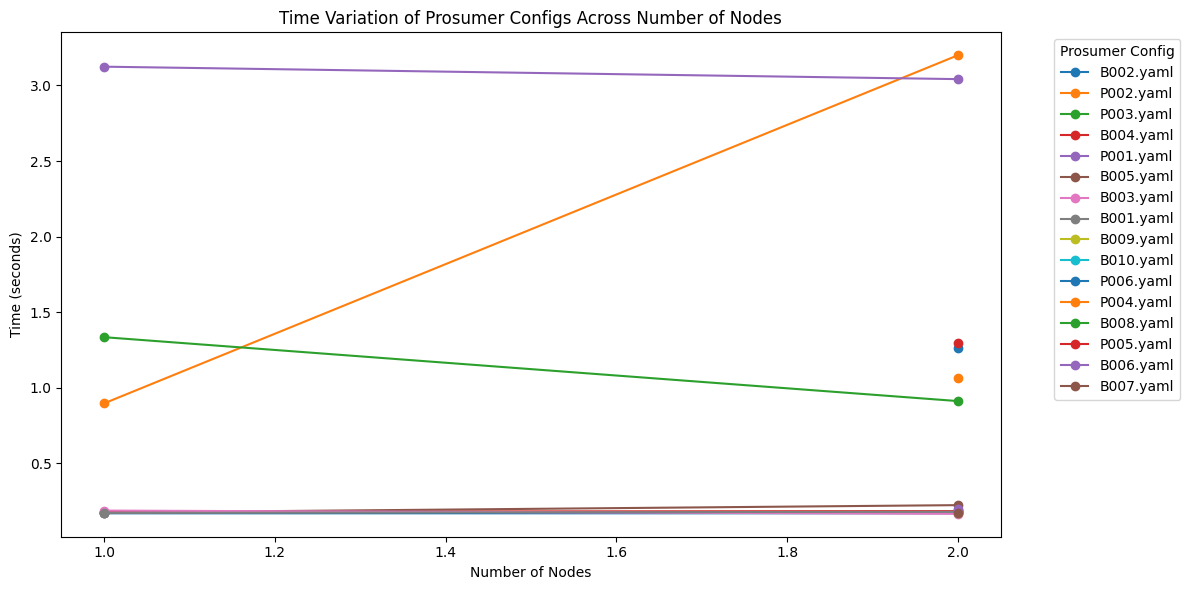

In [25]:
plt.figure(figsize=(12, 6))
for config in experiment_df["prosumer_config"].unique():
    config_data = experiment_df[experiment_df["prosumer_config"] == config]
    plt.plot(config_data["n_nodes"], config_data[time_variable], marker="o", label=config)

plt.title("Time Variation of Prosumer Configs Across Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.legend(title="Prosumer Config", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Discrepancy between market price and dispatched quantity

This code was used to investigate https://gitlab.tudelft.nl/demoses/annular/-/issues/81

In [ ]:
experiment_id = "pypsa-eur-DE-1-nodes-24-timesteps//market_auction_pypsa_eur_DE_1_20250507T_141253Z/"
base_url = "/home/flavio/repositories/projects/DEMOSES/demoses-scaling-benchmarks/flavio_test/"
market_path = f"{base_url}{experiment_id}market.csv"
market = pd.read_csv(market_path, parse_dates=True, index_col=0)
req_cols = ["market_price", "satellite_base_config-P001", "satellite_base_config-P002"]
col_ids = [i for i, x in enumerate(market.columns) if x in req_cols]
market.iloc[0, col_ids]

In [27]:
satellites = ["P001", "P002"]
satellite_data = {}
for s in satellites:
    sat_results = f"satellite_satellite_base_config-{s}_results/"
    datapath = f"{base_url}{experiment_id}{sat_results}"
    bids = pd.read_csv(f"{datapath}bids.csv", parse_dates=True, index_col=0)
    dispatch = pd.read_csv(f"{datapath}dispatch.csv", parse_dates=True, index_col=0)
    satellite_data[s] = {"bids": bids, "dispatch": dispatch}

In [28]:
market_price = 99.068091

In [29]:
df = satellite_data["P001"]["bids"]
time_mask = (df.index.year == 2013) & (df.index.month == 1) & (df.index.day == 1) & (df.index.hour == 0)
price_mask = df["bid-price"] >= market_price
df.loc[time_mask & price_mask]["quantity"].sum()  # corresponds to what is stored in market.csv in first row

-7720.875987285735

In [30]:
df = satellite_data["P002"]["bids"]
time_mask = (df.index.year == 2013) & (df.index.month == 1) & (df.index.day == 1) & (df.index.hour == 0)
price_mask = df["bid-price"] >= market_price
df.loc[time_mask & price_mask]["quantity"].sum()  # corresponds to what is stored in market.csv in first row

4675.721443255683